In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymysql
from sqlalchemy import create_engine

In [2]:
plt.rcParams['font.family']='batang'

In [3]:
#SQL에서 가져오기
conn = pymysql.connect(host='localhost', user='mini1', password='mini1', db='mini1', charset='utf8', autocommit=False, cursorclass=pymysql.cursors.DictCursor)
cursor = conn.cursor()
sql= "select * from elec where year > '2009-12-31';"
cursor.execute(sql)

ful = cursor.fetchall()

In [4]:
ful_df = pd.DataFrame(ful)

In [5]:
ful_df.drop('num',axis=1,inplace=True)

In [6]:
ful2=ful_df.groupby('year').sum().drop('local_id',axis=1).reset_index().astype(int)

In [7]:
sql= "select day, temperature from gwangju_weather where day > '2009-12-31' and day < '2023-01-01';"
cursor.execute(sql)

weather = cursor.fetchall()

In [8]:
tem_df=pd.DataFrame(weather)

In [9]:
tem_df['year']=pd.to_datetime(tem_df.day).dt.year
tem_df['day']=pd.to_datetime(tem_df.day)

In [10]:
tem_df.reset_index(inplace=True)
tem_df.rename(columns=({'index':'num'}),inplace=True)

In [11]:
hilow = pd.concat([pd.pivot_table(data=tem_df, index='year', values='temperature' , aggfunc='max'), \
        pd.pivot_table(data=tem_df, index='year', values='temperature', aggfunc='min')]).sort_index().reset_index()

In [12]:
hilow_df=pd.DataFrame()
temp_df=pd.DataFrame()
for i in range(len(hilow)):
    temp_df=tem_df.loc[(tem_df.year == hilow.year[i]) & (tem_df.temperature == hilow.temperature[i])]
    hilow_df=pd.concat([hilow_df,temp_df])

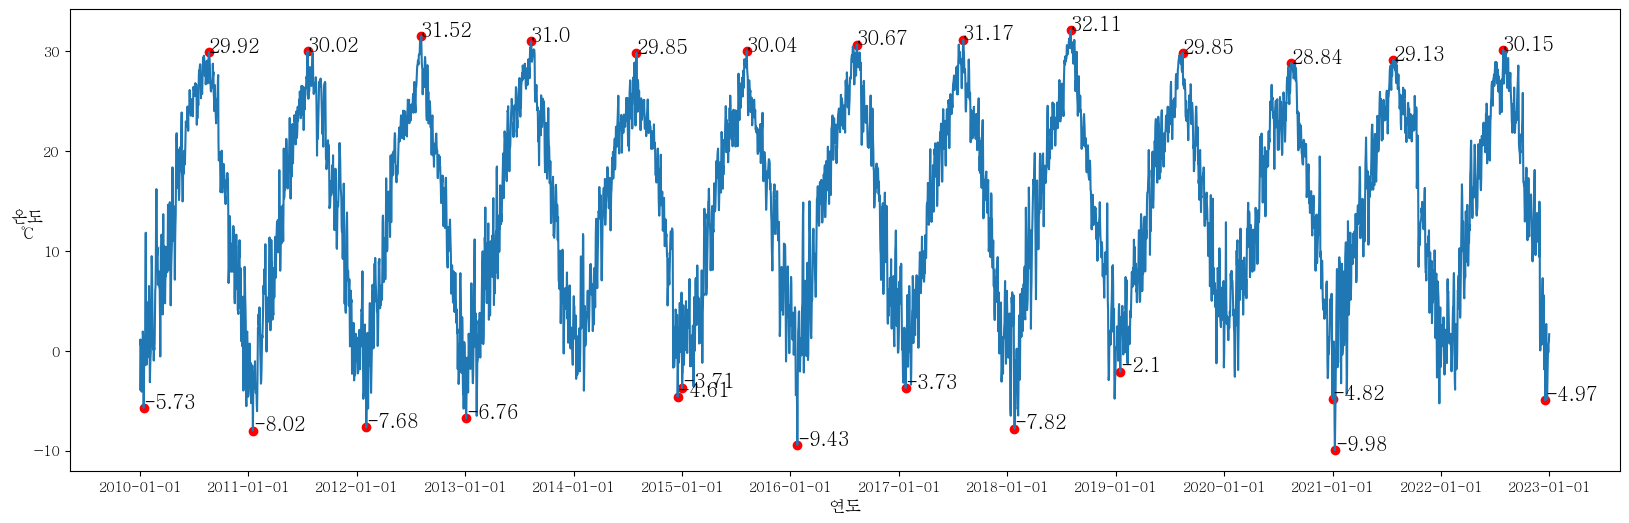

In [13]:
plt.figure(figsize=(20,6))
plt.plot(tem_df.day,tem_df.temperature)
for idx, value in zip(hilow_df.day,hilow_df.temperature):
    plt.scatter(idx,value,color='red')
    plt.annotate(value,(idx,value),fontsize=14)
    plt.xlabel('연도',fontsize=12)
    plt.ylabel('온도\n℃',rotation=0,fontsize=12)
plt.xticks(["2010-01-01","2011-01-01","2012-01-01","2013-01-01","2014-01-01","2015-01-01","2016-01-01","2017-01-01","2018-01-01","2019-01-01","2020-01-01","2021-01-01","2022-01-01","2023-01-01"])
plt.show()

In [14]:
tem2_df=pd.DataFrame(
    {
        '연도':[],
        '온도차':[]
    }
)

In [15]:
y = 2010
for i in range(0,len(hilow),2):
    temp= pd.DataFrame(
        {
            '연도' : [y],
            '온도차' : [abs(hilow.temperature[i]) + abs(hilow.temperature[i+1])]
        }
    )
    tem2_df=pd.concat([tem2_df,temp],ignore_index=True)
    y += 1

In [16]:
tem2_df.연도=tem2_df.연도.astype(int)

C:\Users\user\AppData\Local\Temp\ipykernel_13400\1570286711.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


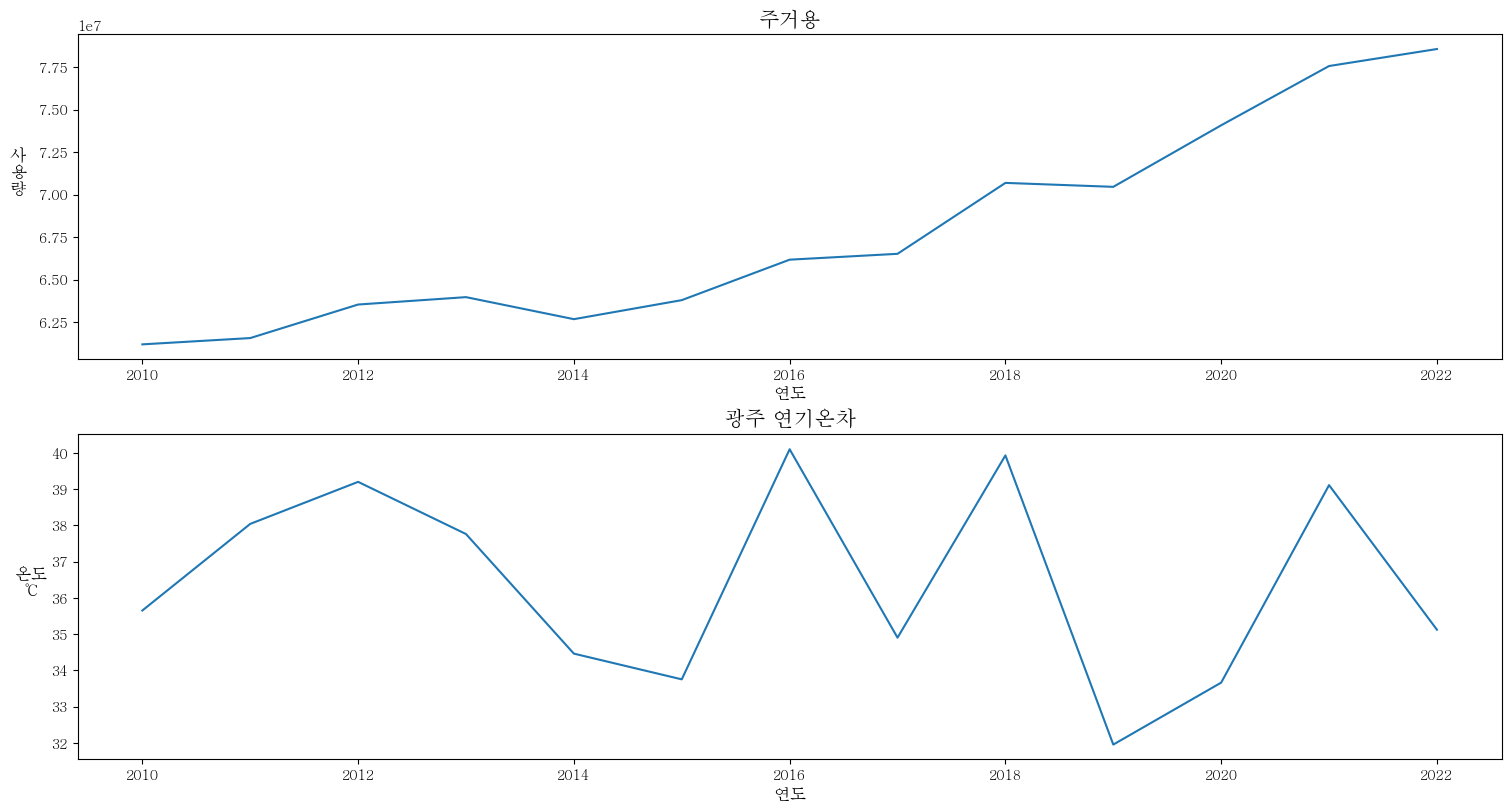

In [17]:
fig, ax = plt.subplots(2,figsize=(15,8), constrained_layout=True)
ax[0].plot(ful2.year,ful2.home)
ax[0].set_title('주거용',fontsize=15)
ax[0].set_xlabel('연도',fontsize=12)
ax[0].set_ylabel('사\n용\n량',fontsize=12,rotation=0,labelpad=15)
ax[1].plot(tem2_df.연도,tem2_df.온도차)
ax[1].set_title("광주 연기온차",fontsize=15)
ax[1].set_xlabel("연도",fontsize=12)
ax[1].set_ylabel("온도\n℃",fontsize=12,rotation=0,labelpad=15)
fig.show()

In [18]:
sql = "select year, sum(value) from home group by year;"
cursor.execute(sql)

home=cursor.fetchall()

In [19]:
home_df = pd.DataFrame(home)

In [20]:
home_df.rename(columns=({'sum(value)':'value'}),inplace=True)

In [21]:
home_df=home_df.astype(int)

C:\Users\user\AppData\Local\Temp\ipykernel_13400\2056362569.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


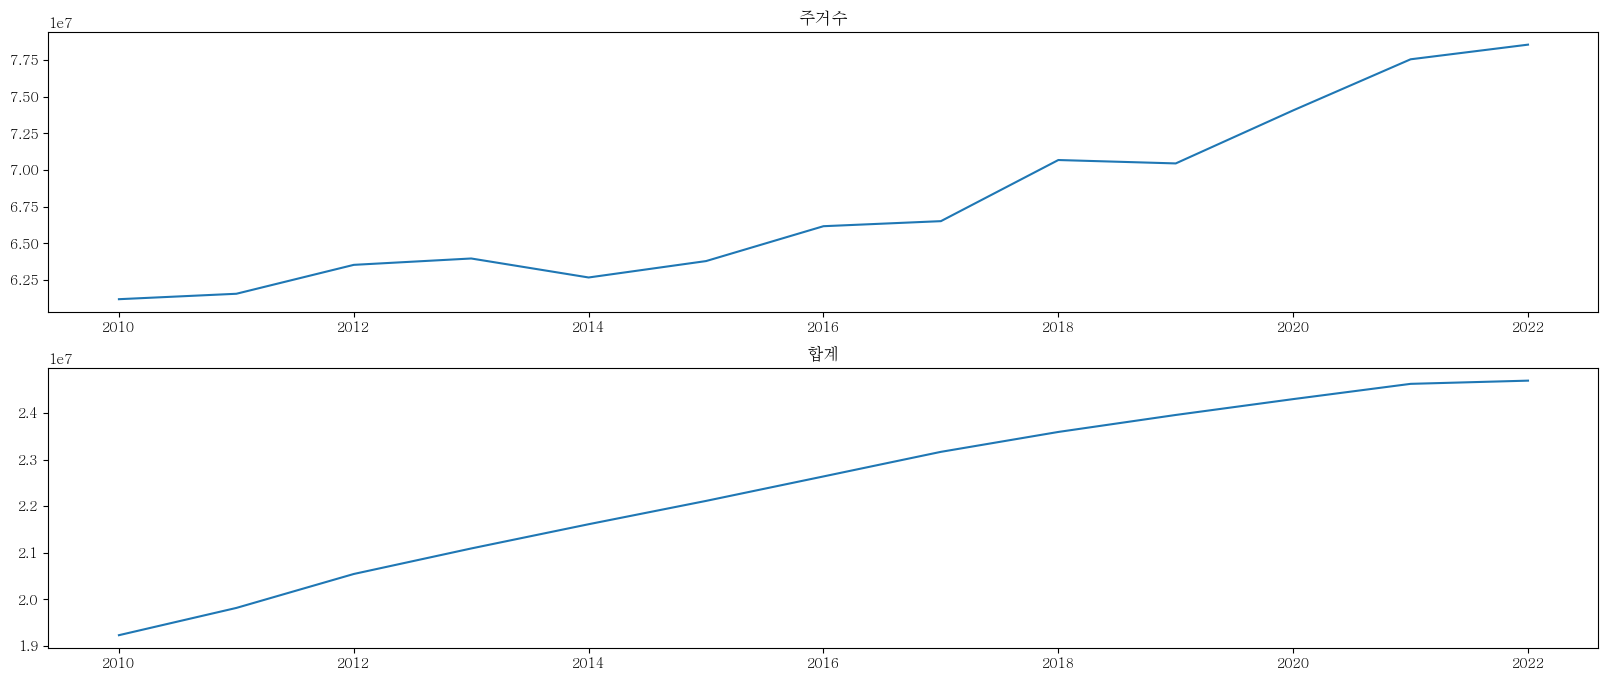

In [22]:
fig, ax = plt.subplots(2,figsize=(20,8))
ax[0].plot(ful2.year,ful2.home)
ax[1].plot(home_df.year,home_df.value)
ax[0].set_title('주거수')
ax[1].set_title('합계')
fig.show()

In [23]:
sql = "select year, sum(value),version from office group by year, version;"
cursor.execute(sql)
office_raw=cursor.fetchall()

In [24]:
office=pd.DataFrame(office_raw).rename(columns=({'sum(value)':'value'}))

In [25]:
office.year=office.year.astype(int)
office.value=office.value.astype(int)

C:\Users\user\AppData\Local\Temp\ipykernel_13400\931471589.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


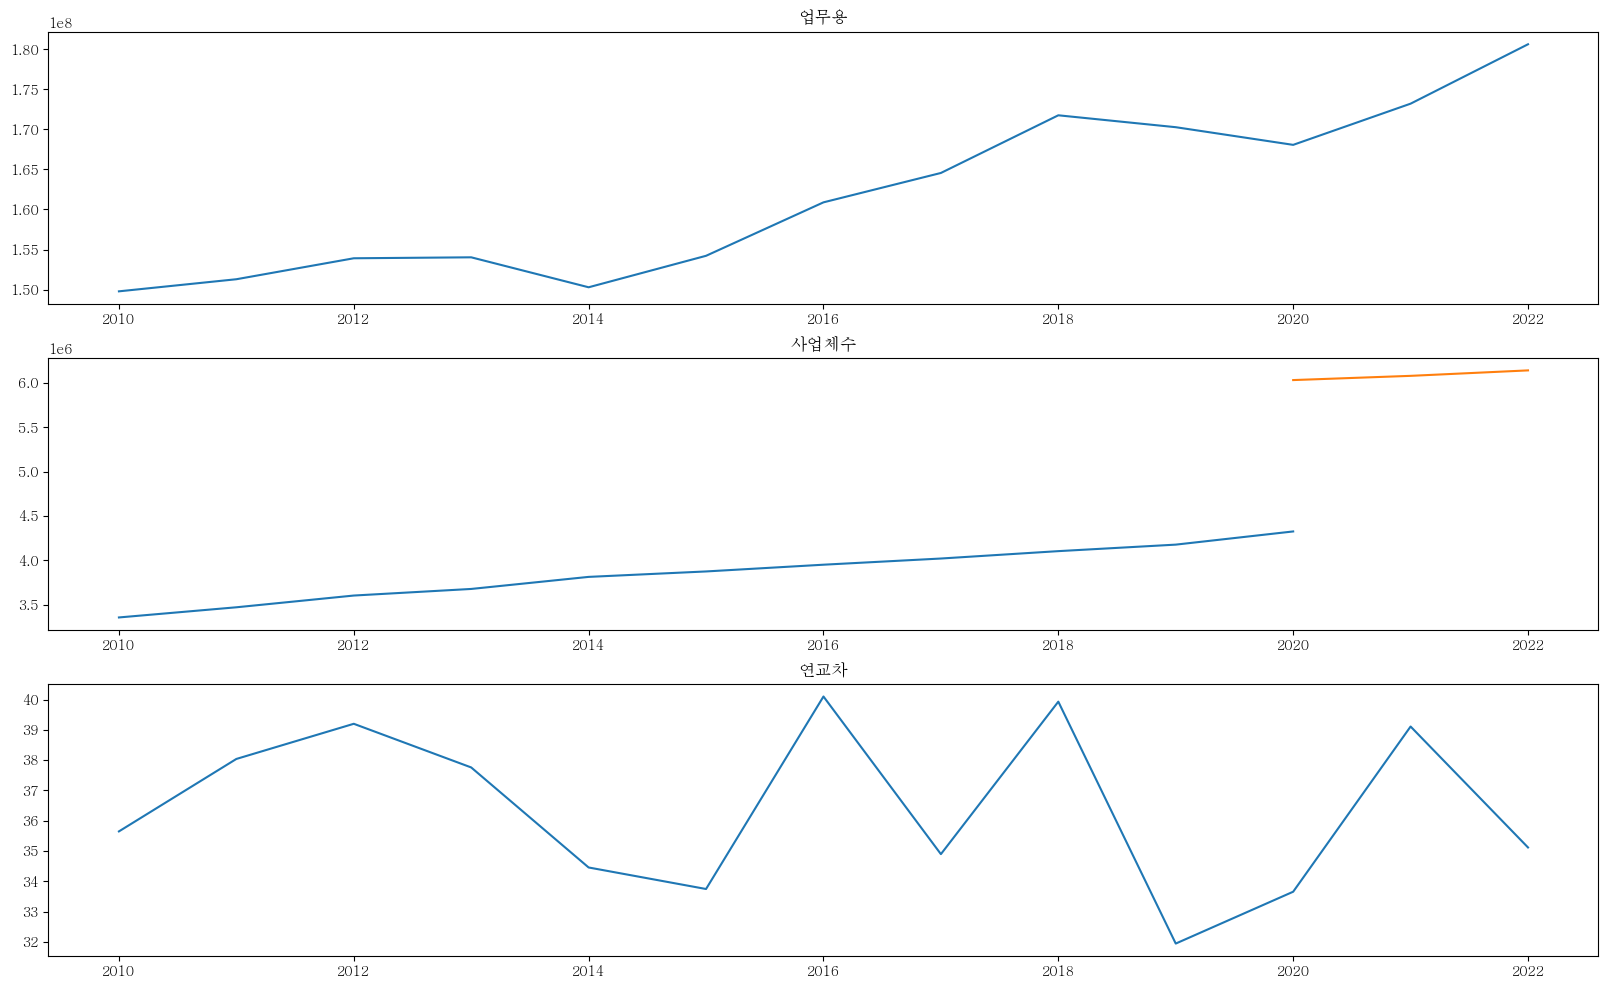

In [26]:
fig, ax = plt.subplots(3,figsize=(20,12))
ax[0].plot(ful2.year,ful2.office)
ax[1].plot(office.year[:11],office.value[:11])
ax[1].plot(office.year[11:],office.value[11:])
ax[2].plot(tem2_df.연도,tem2_df.온도차)
ax[0].set_title('업무용')
ax[1].set_title('사업체수')
ax[2].set_title('연교차')
fig.show()

In [27]:
from fractions import Fraction
import sympy

In [28]:
#home용 상수 구하기
sol=pd.DataFrame()
a, b, c = sympy.symbols('a b c')
for i in range(len(home_df)-2):
    equation1= a*home_df.value[i] + b*tem2_df.온도차[i] - ful2.home[i] + c
    equation2= a*home_df.value[i+1] + b*tem2_df.온도차[i+1] - ful2.home[i+1] + c
    equation3= a*home_df.value[i+2] + b*tem2_df.온도차[i+2] - ful2.home[i+2] + c
    temp=pd.DataFrame(sympy.solve((equation1,equation2,equation3), dict=True))
    sol=pd.concat([sol,temp],ignore_index=True)
sol=sol.astype(float)
sol.mean()

a    5.378237e+00
b    2.644487e+05
c   -6.699041e+07
dtype: float64

In [29]:
#office용 type 1 상수 구하기
sol1=pd.DataFrame()
a, b, c = sympy.symbols('a b c')
for i in range((office.version=='old').sum()-2):
    equation1= a*office.value[i] + b*tem2_df.온도차[i] - ful2.office.values[i] + c
    equation2= a*office.value[i+1] + b*tem2_df.온도차[i+1] - ful2.office.values[i+1] + c
    equation3= a*office.value[i+2] + b*tem2_df.온도차[i+2] - ful2.office.values[i+2] + c
    temp=pd.DataFrame(sympy.solve((equation1,equation2,equation3), dict=True))
    sol1=pd.concat([sol1,temp],ignore_index=True)
sol1=sol1.astype(float)
sol1.mean()

a    6.029975e+01
b    1.625124e+06
c   -1.307608e+08
dtype: float64

In [30]:
#office용 type 2 상수 구하기
sol2=pd.DataFrame()
a, b, c = sympy.symbols('a b c')
for i in (office.loc[office.version=='new'].index[:-2]):
    equation1= a*office.value[i] + b*tem2_df.온도차[i-1] - ful2.office[i-1] + c
    equation2= a*office.value[i+1] + b*tem2_df.온도차[i] - ful2.office[i] + c
    equation3= a*office.value[i+2] + b*tem2_df.온도차[i+1] - ful2.office[i+1] + c
    temp=pd.DataFrame(sympy.solve((equation1,equation2,equation3), dict=True))
    sol2=pd.concat([sol2,temp],ignore_index=True)
sol2=sol2.astype(float)
sol2.mean()

a    1.158883e+02
b   -7.030130e+04
c   -5.286095e+08
dtype: float64

In [31]:
sql = "select * from investment where year > '2008' and year < '2023';"
cursor.execute(sql)
invest_raw=cursor.fetchall()

In [32]:
investment=pd.DataFrame(invest_raw)

In [33]:
investment.year=investment.year.astype(int)

In [34]:
#industry용 상수 구하기
sol3=pd.DataFrame()
a, c = sympy.symbols('a c')
for i in range(len(investment)-2):
    equation1= a*investment.money[i] - ful2.industry[i] + c
    equation2= a*investment.money[i+1] - ful2.industry[i+1] + c
    temp=pd.DataFrame(sympy.solve((equation1, equation2, equation3), dict=True))
    sol3=pd.concat([sol3,temp],ignore_index=True)
sol3=sol3.astype(float)
sol3.mean()

a    1.065416e+03
b   -1.843767e+08
c    1.129323e+08
dtype: float64

In [35]:
tem3_df=pd.concat([tem2_df[:11],tem2_df[10:]],ignore_index=True)

In [36]:
ful3=ful2.set_index('year').T.sum()

In [37]:
#가구수 불러오기
conn = pymysql.connect(host='localhost', user='mini1', password='mini1', db='mini1', charset='utf8', autocommit=False, cursorclass=pymysql.cursors.DictCursor)
cursor = conn.cursor()
sql = "select * from family;"
cursor.execute(sql)

family = pd.DataFrame(cursor.fetchall())

family.drop(['num'], axis=1, inplace=True)

In [38]:
contract=(home_df.value/family.families)

contract.values[7:13].mean()

1.1993944990011935

In [39]:
#계약 호수 에측값
forehome=(1.20*family.families).reset_index().drop(['index'],axis=1)
forehome['year']=family.year
forehome.rename(columns={'families':'expectHome'},inplace=True)

In [40]:
#23년 날씨(10월 4일까지)
sql= "select day, temperature from gwangju_weather where day > '2022-12-31';"
cursor.execute(sql)

weather23 = cursor.fetchall()

foretem=pd.DataFrame(weather23)

In [41]:
foretemdif=abs(foretem.temperature.max())+abs(foretem.temperature.min())

In [42]:
#23년도 연교차 예측치
temp=pd.DataFrame({
    '연도':[2023],
    '온도차':[foretemdif]})

tem3_df=pd.concat([tem3_df,temp],ignore_index=True)
tem4_df=pd.concat([tem2_df,temp],ignore_index=True)

In [43]:
office2=office[:]
office2.index=office2.index+1

In [44]:
#평균적 증가량 계산
pd.concat([(office.value-office2.value)[1:10],(office.value-office2.value)[12:14]])[5:].mean()

68605.66666666667

In [45]:
#평균적 증가량을 통한 사업체 수 일반적 예측값 추가
office.loc[14]=[2023,6141263+68606,'expect']

In [72]:
#예측값들
z=sol[a].mean()*home_df.value+sol[b].mean()*tem2_df.온도차+sol[c].mean()            #가정용
z1=sol1[a].mean()*office.value[:11]+sol1[b].mean()*tem2_df.온도차+sol1[c].mean()    #업무용1
z2=sol2[a].mean()*office.value[11:]+sol2[b].mean()*tem3_df.온도차+sol2[c].mean()    #업무용2
z3=sol3[a].mean()*investment.money+sol3[c].mean()                                  #산업용
z5=sol[a].mean()*forehome.expectHome+sol[b].mean()*tem4_df.온도차+sol[c].mean()    #가정용 계약호수 예측값 이용
z6=pd.concat([z1[:11],z2[11:]])                                                   #사업체 수 일반적 증가량을 이용한 예측값
temp=pd.concat([z6[:10],z6[11:]],ignore_index=True) #사업체 중복값을 무시하기 위한 임시 데이터프레임
z4=z5[:14] + temp + z3  #예측치총 합계

C:\Users\user\AppData\Local\Temp\ipykernel_13400\3551489401.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


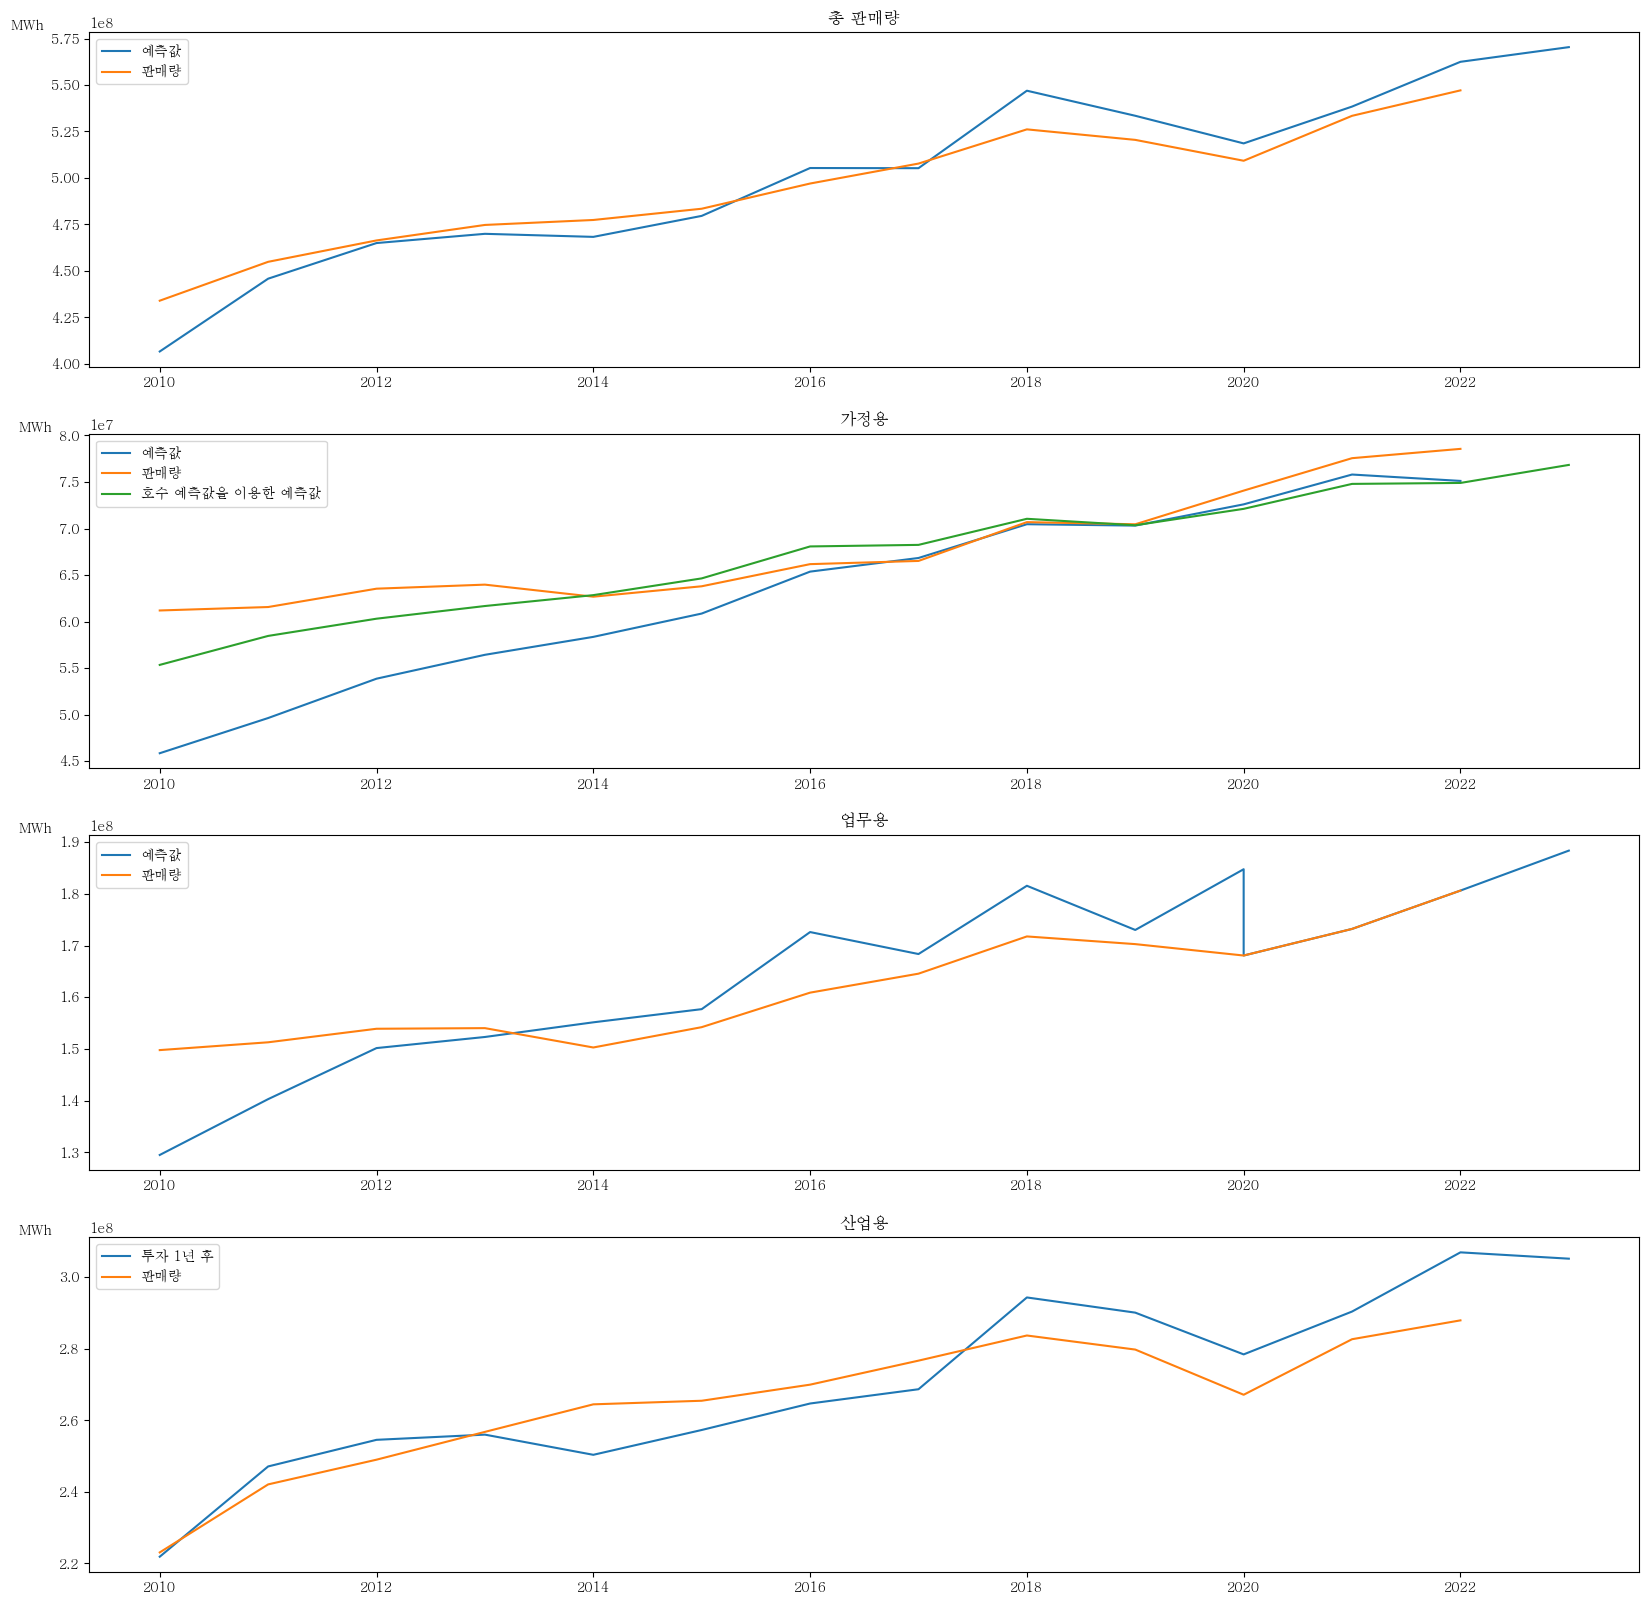

In [47]:
#그래프
fig, ax = plt.subplots(4,figsize=(20,20))
ax[0].plot(forehome.year[:14].astype(int),z4,label='예측값')
ax[0].plot(ful3.index,ful3.values, label='판매량')
ax[0].set_ylabel('MWh',rotation=0,labelpad=5,loc='top')
ax[0].set_title("총 판매량")
ax[0].legend()

ax[1].plot(tem2_df.연도,(z),label='예측값')
ax[1].plot(ful2.year,ful2.home,label='판매량')
ax[1].plot(forehome.year.astype(int),z5,label='호수 예측값을 이용한 예측값')
ax[1].set_title("가정용")
ax[1].set_ylabel('MWh',rotation=0,labelpad=5,loc='top')
ax[1].legend()

ax[2].plot(office.year,z6.values,label='예측값')
ax[2].plot(ful2.year,ful2.office,label='판매량')
ax[2].set_title("업무용")
ax[2].set_ylabel('MWh',rotation=0,labelpad=5,loc='top')
ax[2].legend()

ax[3].plot(investment.year+1,z3,label='투자 1년 후')
ax[3].plot(ful2.year,ful2.industry,label='판매량')
ax[3].set_title("산업용")
ax[3].set_ylabel('MWh',rotation=0,labelpad=5,loc='top')
ax[3].legend()

fig.show()

In [48]:
conn.close()

In [94]:
#발생중 1년당 가정용에 대한 영향력
(((ful2.home-z5)[11]-(ful2.home-z5)[10])+((ful2.home-z5)[12]-(ful2.home-z5)[11]))/2

850294.9400437176

In [49]:
#추가 준비

In [50]:
conn = pymysql.connect(host='localhost', user='mini1', password='mini1', db='mini1', charset='utf8', autocommit=False, cursorclass=pymysql.cursors.DictCursor)
cursor = conn.cursor()
sql = "select * from infection_rate_data;"
cursor.execute(sql)

infection = pd.DataFrame(cursor.fetchall())

In [51]:
sql = "select * from infection_ages where year < '2023';"
cursor.execute(sql)

infection_age = pd.DataFrame(cursor.fetchall())

In [52]:
sql  = "select * from population_ages where year < '2023';"
cursor.execute(sql)

ages=pd.DataFrame(cursor.fetchall())

In [53]:
sql = "select * from power_data;"
cursor.execute(sql)

power=pd.DataFrame(cursor.fetchall())

In [54]:
conn.close()

In [55]:
infection_age=infection_age.iloc[:,1:]

In [56]:
ages=ages.iloc[:,1:]

In [57]:
power=power.iloc[:,1:]

In [58]:
conn = pymysql.connect(host='localhost', user='mini1', password='mini1', db='mini1', charset='utf8', autocommit=False, cursorclass=pymysql.cursors.DictCursor)
cursor = conn.cursor()
sql = "select i.local_id, i.year, i.month, i.population, i.confirmed_case, i.infection_rate, p.home, p.office, p.industry from infection_rate_data i, power_data p where i.year=p.year and i.local_id=p.local_id and i.month = p.month;"
cursor.execute(sql)

power_infection = pd.DataFrame(cursor.fetchall())
conn.close()

In [59]:
power_infection[['year','month']]= power_infection[['year','month']].astype(int)

In [60]:
test=power_infection.groupby(['year','month']).sum().reset_index().sort_values(by=['year','month']).drop(['local_id'],axis=1)

In [61]:
test['infection_rate']=round(test.confirmed_case/test.population*100,2)

In [62]:
tem_df['month']=pd.to_datetime(tem_df.day).dt.month

In [63]:
tem_mon=round(tem_df.groupby(['year','month']).mean().drop(['num','day'],axis=1),2).reset_index()

In [64]:
tem_mon=tem_mon.loc[(tem_mon.year > 2019) & (tem_mon.year < 2023)].reset_index().drop(['index'],axis=1)

In [65]:
# 아래 gif의 그래프 모두 출력
# fig, ax = plt.subplots(len(test)-1,4,figsize=(20,len(test)*5))
# for i in range(len(test)-1):
    
#     ax[i,0].bar(['Home','Office','Industry'],[test.home.values[i+1]-test.home.values[i],test.office.values[i+1]-test.office.values[i],test.industry.values[i+1]-test.industry.values[i]])
#     ax[i,0].set_title(f'{test.year[i]}.{test.month[i]} ~ {test.year[i+1]}.{test.month[i+1]} 판매량 차이')
#     ax[i,0].set_ylabel('MWh', loc='top', rotation=0,labelpad=-7)

#     ax[i,1].plot(test.index[:i+1],test.confirmed_case[:i+1])
#     ax[i,1].plot(test.index[i:i+2],test.confirmed_case[i:i+2],'r-o')
#     ax[i,1].set_title(f'{test.year[0]}.{test.month[0]} ~ {test.year[i+1]}.{test.month[i+1]} 중 월 감염자 수')
#     ax[i,1].set_ylabel('명', loc='top', rotation=0,labelpad=-7)
#     ax[i,1].set_xlim(-1,36)

#     ax[i,2].pie(infection_age.values[i+1][3:], autopct='%.2f%%', labels=infection_age.columns[3:])
#     ax[i,2].set_title(f"{test.year[i+1]}.{test.month[i+1]} 연령별 감염자수 비율")

#     ax[i,3].plot(tem_mon.index[:i+1],tem_mon.temperature[:i+1])
#     ax[i,3].plot(tem_mon.index[i:i+2],tem_mon.temperature[i:i+2], 'r-o')
#     ax[i,3].set_title(f'{test.year[0]}.{test.month[0]} ~ {test.year[i+1]}.{test.month[i+1]} 중 월 평균 기온')
#     ax[i,3].set_ylabel('℃', loc='top', rotation=0,labelpad=-7)
#     ax[i,3].set_xlim(-1,36)

# fig.show()

C:\Users\user\AppData\Local\Temp\ipykernel_13400\322098156.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


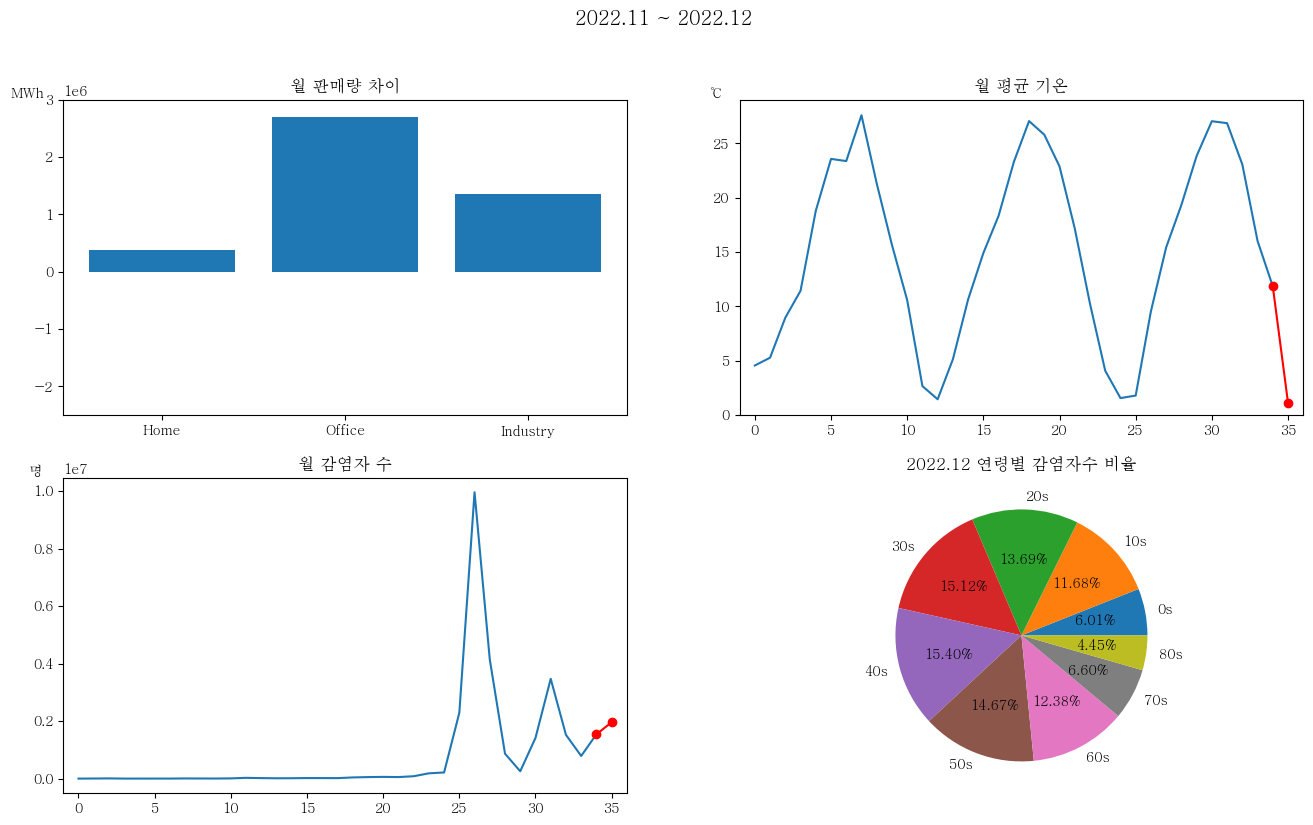

In [66]:
from matplotlib.animation import PillowWriter   #gif출력용

metadata = dict(title = 'Selling and COVID', artist='Gavin' )
writer = PillowWriter(fps=4, metadata=metadata)

fig, ax = plt.subplots(2,2,figsize=(16,9))

#설명용 파일은 writer의 fps값을 1, writer.saving의 파일명에 SellPerMon.gif
#흐름 보여주기용 파일은 writer의 fps값을 4, writer.saving의 파일명에 ShowSellPerMon.gif
with writer.saving(fig, "ShowSellPerMon.gif", 100):
    for i in range(len(test)-1):
        fig.suptitle(f'{test.year[i]}.{test.month[i]} ~ {test.year[i+1]}.{test.month[i+1]}',fontsize=14)
        #판매량 차 그래프
        ax[0,0].cla()
        ax[0,0].bar(['Home','Office','Industry'],[test.home.values[i+1]-test.home.values[i],test.office.values[i+1]-test.office.values[i],test.industry.values[i+1]-test.industry.values[i]])
        ax[0,0].set_title('월 판매량 차이')
        ax[0,0].set_ylabel('MWh', loc='top', rotation=0,labelpad=-7)
        ax[0,0].set_ylim(-2.5e6,3e6)

        #월 감염자수 그래프
        ax[1,0].cla()
        ax[1,0].plot(test.index[:i+1],test.confirmed_case[:i+1],color='tab:blue')
        ax[1,0].plot(test.index[i:i+2],test.confirmed_case[i:i+2],'r-o')
        ax[1,0].set_title('월 감염자 수')
        ax[1,0].set_ylabel('명', loc='top', rotation=0,labelpad=-7)
        ax[1,0].set_xlim(-1,36)

        #감염자 연령비 그래프
        ax[1,1].cla()
        ax[1,1].pie(infection_age.values[i+1][3:], autopct='%.2f%%', labels=infection_age.columns[3:])
        ax[1,1].set_title(f"{test.year[i+1]}.{test.month[i+1]} 연령별 감염자수 비율")

        #월 평균기온 그래프
        ax[0,1].cla()
        ax[0,1].plot(tem_mon.index[:i+1],tem_mon.temperature[:i+1],color='tab:blue')
        ax[0,1].plot(tem_mon.index[i:i+2],tem_mon.temperature[i:i+2], 'r-o')
        ax[0,1].set_title('월 평균 기온')
        ax[0,1].set_ylabel('℃', loc='top', rotation=0,labelpad=-7)
        ax[0,1].set_xlim(-1,36)
        ax[0,1].set_ylim(0,29)

        writer.grab_frame()
        fig.show()
        

In [67]:
#코로나 기간 평균 변화량(2020~2022)
#산업용은 코로나 영향이 미비하다고 생각되어 제외
co_period=pd.DataFrame()
co_period['home']=(ful2.home-z)[10:]
co_period['office']=(ful2.home-z2)[11:]
co_period.office[10]=(ful2.home-z1)[10]
print(f'코로나 기간 동안 가정용은 {round(co_period.mean().home,2)}MWh 만큼, 업무용은 {round(co_period.mean().office,2)}MWh 만큼 변화하였습니다.')
print(f'결과적으로 평균 {round(co_period.mean().sum(),2)}MWh 만큼의 차이가 발생되었습니다.')

코로나 기간 동안 가정용은 2225619.68MWh 만큼, 업무용은 -98610732.08MWh 만큼 변화하였습니다.
결과적으로 평균 -96385112.4MWh 만큼의 차이가 발생되었습니다.
